In [1]:
import pickle
import clip
import socket
import numpy as np
import torch
from utils import nethook

%reload_ext autoreload
%autoreload 2

print("Hostname: " + socket.gethostname())
print("Torch version:", torch.__version__)
torch.cuda.empty_cache()

Hostname: sx-el-121920
Torch version: 1.13.0a0+d0d6b1f


In [2]:
# general configuration
ROOT_PATH = "/mnt/data/patrick.koller/masterthesis/data"

# simplify problem
USE_ALL_CLIP_LAYERS = False
USE_ALL_STANDALONE_LAYERS = False

# dataset parameters
DATASET_BATCH_SIZE = 10
DATASET_SHUFFLE = True
DATASET_TEST_FOOL_RANDOM_COLORS = True

# set device (for number crunching)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# load standalone model

In [4]:
standalone_model = pickle.load(open(f"{ROOT_PATH}/results/standalone_resnet50_biased.mdl", 'rb'))
standalone_model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# make sure that all standalone resnet50 parameters are floating point variables (paranoia)
for p in standalone_model.parameters(): 
    p.data = p.data.float() 

In [6]:
standalone_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# generate list of conv layers
if USE_ALL_STANDALONE_LAYERS:
    standalone_layers = []
    for name, layer in standalone_model.named_modules():
        if "conv" in name:
            standalone_layers.append(name)
            
    print(f"Number of layers: {len(standalone_layers)}")
else:
    standalone_layers = ['layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3', 'layer1.1.conv1', 'layer1.1.conv2']

standalone_layers

['layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.0.conv3',
 'layer1.1.conv1',
 'layer1.1.conv2']

In [8]:
# hook layers for standalone model
standalone_model.eval()
standalone_model = nethook.InstrumentedModel(standalone_model)
standalone_model.retain_layers(standalone_layers)

# load CLIP model

In [9]:
clip_model, clip_preprocess = clip.load("RN50")
clip_model.cuda().eval()

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [10]:
# make sure that all clip parameters are floating point variables (paranoia)
for p in clip_model.parameters(): 
    p.data = p.data.float() 

In [11]:
# save layers to be swapped
if USE_ALL_CLIP_LAYERS:
    clip_layers = []
    for name, layer in clip_model.named_modules():
        if "conv" in name:
            clip_layers.append(name)
    # or
    # clip_layers = [ "visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
else:
    # clip_layers = ["visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
    clip_layers = ['visual.layer1.0.conv1', 'visual.layer1.0.conv2', 'visual.layer1.0.conv3', 'visual.layer1.1.conv1', 'visual.layer1.1.conv2']
          
print(f"Number of layers: {len(clip_layers)}")
clip_layers

Number of layers: 5


['visual.layer1.0.conv1',
 'visual.layer1.0.conv2',
 'visual.layer1.0.conv3',
 'visual.layer1.1.conv1',
 'visual.layer1.1.conv2']

In [12]:
# hook layers for clip model
clip_model.eval()
clip_model = nethook.InstrumentedModel(clip_model)
clip_model.retain_layers(clip_layers)

# load datasets

In [13]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

MNIST dataset already exists
Number of samples: 2000


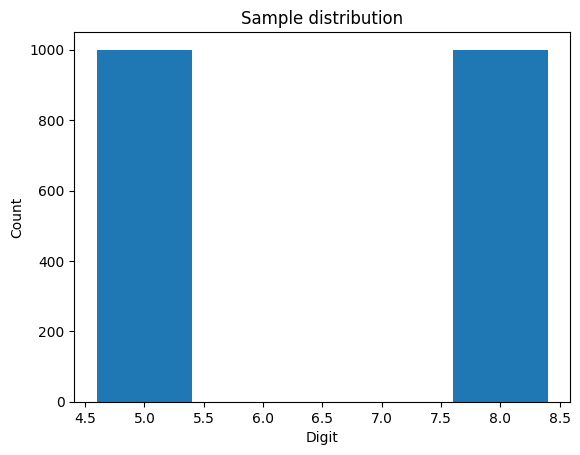

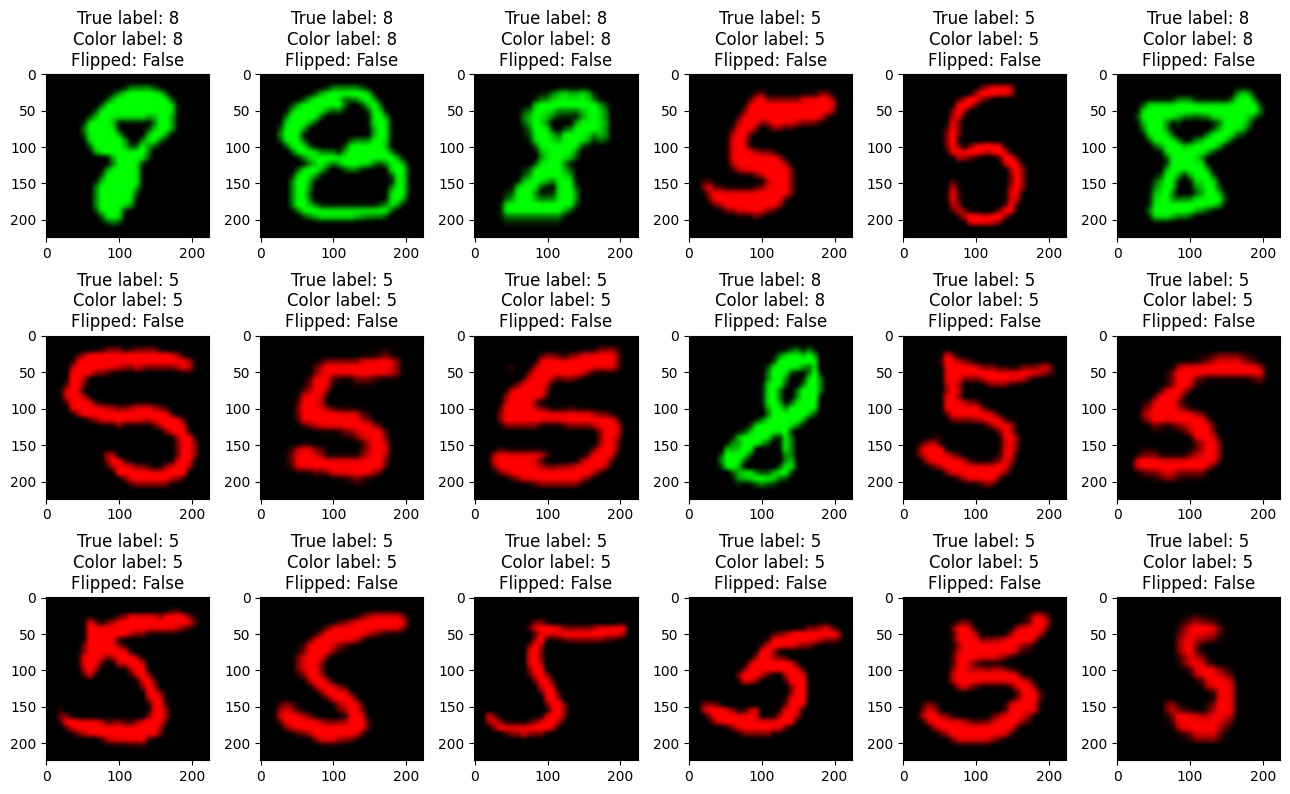

In [14]:
from torchvision import transforms

# initialize dataset
data_set = DatasetMNIST(root=ROOT_PATH,
                        env='test',
                        color=True,
                        opt_postfix="2classes",
                        filter=[5,8],
                        first_color_max_nr=5,
                        preprocess=clip_preprocess,
                        test_fool_random=DATASET_TEST_FOOL_RANDOM_COLORS,
                        transform= transforms.Compose([transforms.ToTensor()]))

# create dataloaders
data_loader = torch.utils.data.DataLoader(dataset=data_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

print(f"Number of samples: {len(data_loader.dataset.data_label_tuples)}")
digit_distribution(data_set)
plot_digits(data_set, clip_preprocess)

# compute statistics

In [15]:
from torchvision import transforms

def get_mean_std(standalone_model, standalone_layers, clip_model, clip_layers, dataloader, batch_size, device):
    print("Collecting Dataset Statistics")
    
    standalone_model_stats_list = []
    clip_model_stats_list = []
    
    # batch processing
    with torch.no_grad():
        for iteration, data in enumerate(dataloader):
            
            # copy data to GPU
            inputs, _, _, _ = data
            inputs = inputs.to(device)
            
            print(f"Batch {iteration} is being processed...")
            
            ###############################################################################
            # Compute activations and statistics for standalone model
            ###############################################################################
            
            # inference
            _ = standalone_model(inputs)

            # store activations from current batch
            standalone_model_activations = {}
            for layer in standalone_layers:
                standalone_model_activations[layer] = []    
                standalone_model_activation = standalone_model.retained_layer(layer, clear = True)
                standalone_model_activations[layer].append(standalone_model_activation)
            
            # compute statistics (mean and standard deviation)
            batch_standalone_model_stats_list = []
            for layer in standalone_layers:
                standalone_model_activations[layer] = torch.cat(standalone_model_activations[layer], 0) # images x channels x m x m
                standalone_model_activations[layer] = torch.permute(standalone_model_activations[layer], (1,0,2,3)).contiguous() # channels x images x m x m
                standalone_model_activations[layer] = standalone_model_activations[layer].view(standalone_model_activations[layer].shape[0], -1) 
                batch_standalone_model_stats_list.append([torch.mean(standalone_model_activations[layer],dim=-1, dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                      torch.std(standalone_model_activations[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])

            # cleanup
            del standalone_model_activations
            standalone_model_stats_list.append(batch_standalone_model_stats_list)

            ###############################################################################
            # Compute activations and statistics for clip model
            ###############################################################################

            # inference
            _ = clip_model.model.encode_image(inputs)

            # store activations from current batch
            clip_model_activations = {}
            for layer in clip_layers:
                clip_model_activations[layer] = []    
                clip_model_activation = clip_model.retained_layer(layer, clear = True)
                clip_model_activations[layer].append(clip_model_activation)

            # compute statistics (mean and standard deviation)
            batch_clip_model_stats_list = []
            clip_model_stats_list.append(batch_clip_model_stats_list)
            for layer in clip_layers:
                clip_model_activations[layer] = torch.cat(clip_model_activations[layer], 0)
                clip_model_activations[layer] = torch.permute(clip_model_activations[layer], (1,0,2,3)).contiguous()
                clip_model_activations[layer] = clip_model_activations[layer].view(clip_model_activations[layer].shape[0], -1)
                batch_clip_model_stats_list.append([torch.mean(clip_model_activations[layer], dim=-1, dtype=torch.float64).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device),\
                                      torch.std(clip_model_activations[layer], dim=-1).unsqueeze(0).unsqueeze(2).unsqueeze(3).to(device)])

            # cleanup
            del clip_model_activations
            torch.cuda.empty_cache()
            
        print("Done Iteration for Stats")

        ###############################################################################
        # All batches processed, create final statistics
        ###############################################################################
        # compute final stats for standalone model
        final_standalone_model_stats_list = []

        for iii in range(len(batch_standalone_model_stats_list)):
            means = torch.zeros_like(batch_standalone_model_stats_list[iii][0])
            stds = torch.zeros_like(batch_standalone_model_stats_list[iii][1])
            for jjj in range((iteration+1)):
                means+=standalone_model_stats_list[jjj][iii][0]
                stds+=standalone_model_stats_list[jjj][iii][1]**2

            final_standalone_model_stats_list.append([means/(iteration+1), torch.sqrt(stds/(iteration+1))])
        
        # compute final stats for clip model
        final_clip_model_stats_list = []

        for iii in range(len(batch_clip_model_stats_list)):
            means = torch.zeros_like(batch_clip_model_stats_list[iii][0])
            stds = torch.zeros_like(batch_clip_model_stats_list[iii][1])
            for jjj in range((iteration+1)):
                means+=clip_model_stats_list[jjj][iii][0]
                stds+=clip_model_stats_list[jjj][iii][1]**2

            final_clip_model_stats_list.append([means/(iteration+1), torch.sqrt(stds/(iteration+1))])

    return final_standalone_model_stats_list, final_clip_model_stats_list

In [16]:
def save_array(array, filename):
    open_file = open(filename, "wb")
    pickle.dump(array, open_file)
    open_file.close()

In [17]:
def store_activs(model, layers):
    activs = []
    for layer in layers:
        activation = model.retained_layer(layer, clear = True)
        activs.append(activation)
        
    return activs

In [18]:
def dict_layers(activs):
    all_layers = {}
    for iii, activ in enumerate(activs):
        all_layers[activs[iii]] = activ.shape[1]
    return all_layers

In [19]:
def normalize(activation, stats_table):
    eps = 0.00001
    norm_input = (activation- stats_table[0])/(stats_table[1]+eps)
    
    return norm_input

In [20]:
def save_array(array, filename):
    open_file = open(filename, "wb")
    pickle.dump(array, open_file)
    open_file.close()

In [21]:
def create_final_table(all_match_table, standalone_dict, clip_dict, batch_size, device ):
    num_activs_standalone = sum(standalone_dict.values())
    num_activs_clip = sum(clip_dict.values())
    final_match_table = torch.zeros((num_activs_standalone, num_activs_clip)).to(device)
    
    standalone_activ_count = 0 
    for ii in range(len(all_match_table)):
        clip_activ_count = 0
        for jj in range(len(all_match_table[ii])):
            num_standalone_activs = all_match_table[ii][0].shape[0]
            num_clip_activs = all_match_table[0][jj].shape[1]
            final_match_table[standalone_activ_count: standalone_activ_count+num_standalone_activs, \
                            clip_activ_count:clip_activ_count+num_clip_activs] = all_match_table[ii][jj]
            clip_activ_count += num_clip_activs
        standalone_activ_count += num_standalone_activs
    return final_match_table

# activation matching

In [22]:
from utils import matching, nethook, stats

def activation_matching(standalone_model, standalone_layers, clip_model, clip_layers, dataloader, batch_size, save_path, device):
    
    # compute dataset statistics
    standalone_model_statistics_table, clip_model_statistics_table = get_mean_std(standalone_model, standalone_layers, clip_model, clip_layers, dataloader, batch_size, device)
    save_array(standalone_model_statistics_table, f"{save_path}/standalone_model_statistics.pkl")
    save_array(clip_model_statistics_table, f"{save_path}/clip_model_statistics.pkl")
    
    print("Done")
    print("Starting Activation Matching")
    
    for iteration, data in enumerate(dataloader):
        with torch.no_grad():

            # copy data to GPU
            inputs, _, _, _ = data
            inputs = inputs.to(device)
            
            print(f"Batch {iteration} is being processed...")
            
            # inference standalone model
            _ = standalone_model(inputs)
            
            # append standalone model layer-activations for each layer
            standalone_model_activations = store_activs(standalone_model, standalone_layers)

            # inference clip model
            _ = clip_model.model.encode_image(inputs)

            # append clip model layer-activations for batch
            clip_model_activations =  store_activs(clip_model, clip_layers)

            # create dictionary of activations in layers and number of activations
            all_standalone_layers = dict_layers(standalone_model_activations)
            all_clip_layers = dict_layers(clip_model_activations)
            
            # create empty table of size: "number of convolution kernels in standalone model" x "number of convolution kernels in clip model"
            if iteration == 0:
                num_standalone_model_activations = sum(all_standalone_layers.values())
                num_clip_model_activations = sum(all_clip_layers.values())
                final_match_table = torch.zeros((num_standalone_model_activations, num_clip_model_activations)).to(device)

            # matching
            all_match_table = []

            for ii, standalone_model_activation in enumerate(standalone_model_activations):
                match_table = []
                standalone_model_activation = normalize(standalone_model_activation, standalone_model_statistics_table[ii])

                for jj, clip_model_activation in enumerate(clip_model_activations):
                    clip_model_activation_scaled = normalize(clip_model_activation, clip_model_statistics_table[jj]) 
                    # scale maps to same size
                    map_size = max((standalone_model_activation.shape[2], clip_model_activation.shape[2]))
                    standalone_model_activation_scaled = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(standalone_model_activation)
                    clip_model_activation_scaled = torch.nn.Upsample(size=(map_size,map_size), mode='bilinear')(clip_model_activation_scaled)
                    # einsum(..) sums the product of the elements of the input.
                    # examples: https://stackoverflow.com/questions/55894693/understanding-pytorch-einsum
                    scores = torch.einsum('aixy,ajxy->ij', standalone_model_activation_scaled, clip_model_activation_scaled)/(batch_size*map_size**2)  
                    scores = scores.cpu()
                    
                    match_table.append(scores)
                    del standalone_model_activation_scaled
                    del clip_model_activation_scaled
                    del scores
                    
                all_match_table.append(match_table)
                del match_table

            # create table
            batch_match_table = create_final_table(all_match_table, all_standalone_layers, all_clip_layers, batch_size, device)
            final_match_table += batch_match_table
            save_array(final_match_table, f"{save_path}/norm_table_"+str(iteration)+".pkl")

            # cleanup
            del all_match_table
            del batch_match_table
            del standalone_model_activations
            del clip_model_activations
            torch.cuda.empty_cache()
            
    # average and save
    final_match_table /= len(dataloader)
    save_array(final_match_table, f"{save_path}/table.pkl")
    

In [23]:
import time

start_time = time.time()

activation_matching(standalone_model, standalone_layers,
                    clip_model, clip_layers,
                    dataloader=data_loader,
                    batch_size=DATASET_BATCH_SIZE,
                    save_path=f"{ROOT_PATH}/results",
                    device=device
                    )   

end_time = time.time()

print(f"Runtime: {np.round(end_time - start_time, 3)}s")

Batch 0 is being processed...
Batch 1 is being processed...
Batch 2 is being processed...
Batch 3 is being processed...
Batch 4 is being processed...
Batch 5 is being processed...
Batch 6 is being processed...
Batch 7 is being processed...
Batch 8 is being processed...
Batch 9 is being processed...
Batch 10 is being processed...
Batch 11 is being processed...
Batch 12 is being processed...
Batch 13 is being processed...
Batch 14 is being processed...
Batch 15 is being processed...
Batch 16 is being processed...
Batch 17 is being processed...
Batch 18 is being processed...
Batch 19 is being processed...
Batch 20 is being processed...
Batch 21 is being processed...
Batch 22 is being processed...
Batch 23 is being processed...
Batch 24 is being processed...
Batch 25 is being processed...
Batch 26 is being processed...
Batch 27 is being processed...
Batch 28 is being processed...
Batch 29 is being processed...
Batch 30 is being processed...
Batch 31 is being processed...
Batch 32 is being 

In [24]:
def load_stats(root, device):

    # load table
    file_name = os.path.join(root, "table.pkl")
    with open(file_name, 'rb') as f:
        table = pickle.load(f)
        table = table.to(device)
    
    # load statistics from standalone model
    with open(os.path.join(root,"standalone_model_statistics.pkl"), 'rb') as f:
        standalone_statistics = pickle.load(f)
        for iii, item1 in enumerate(standalone_statistics):
            for jjj, item2 in enumerate(standalone_statistics[iii]):
                standalone_statistics[iii][jjj] = standalone_statistics[iii][jjj].to(device)
                
    # load statistics from clip model
    with open(os.path.join(root,"clip_model_statistics.pkl"), 'rb') as f:
        clip_statistics = pickle.load(f)
        
        for iii, item1 in enumerate(clip_statistics):
            for jjj, item2 in enumerate(clip_statistics[iii]):
                clip_statistics[iii][jjj] = clip_statistics[iii][jjj].to(device)
        
    return table, standalone_statistics, clip_statistics

In [25]:
table, standalone_statistics, clip_statistics = load_stats(f"{ROOT_PATH}/results", device)
# table, standalone_statistics, clip_statistics = load_stats(f"/mnt/data/patrick.koller/masterthesis/data/results/backup/results", device)


########################################
# table
########################################
# number of kernels in standalone model x number of kernels in clip model
# and therefore, since every kernel results in one activation/feature map:
# num_standalone_model_activations x num_clip_model_activations
print(f"{table.shape=}")


########################################
# Standalone statistics
########################################
# len(standalone_statistics) = 49 conv layers
# len(standalone_statistics[0]) = 2 => Choose between mean [0] or std [1]
# standalone_statistics[0][0].shape = torch.Size([1, 64, 1, 1]) => 64 activations maps of the 64 conv kernels in first layer

nr_feature_maps_standalone = 0

for i in range(len(standalone_statistics)):
    nr_feature_maps_standalone += standalone_statistics[i][0].shape[1]
    
print(f"Number of feature maps in standalone model:{nr_feature_maps_standalone}")


########################################
# CLIP statistics
########################################
# len(clip_statistics) = 51 conv layers
# len(clip_statistics[0]) = 2 => Choose between mean [0] or std [1]
# clip_statistics[0][0].shape = torch.Size([1, 32, 1, 1]) => 32 activations maps of the 32 conv kernels in first layer

nr_feature_maps_clip = 0

for i in range(len(clip_statistics)):
    nr_feature_maps_clip += clip_statistics[i][0].shape[1]
    
print(f"Number of feature maps in CLIP image-encoder:{nr_feature_maps_clip}")

table.shape=torch.Size([512, 512])
Number of feature maps in standalone model:512
Number of feature maps in CLIP image-encoder:512


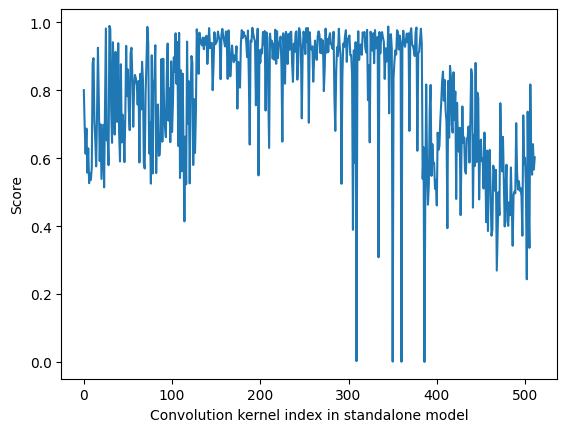

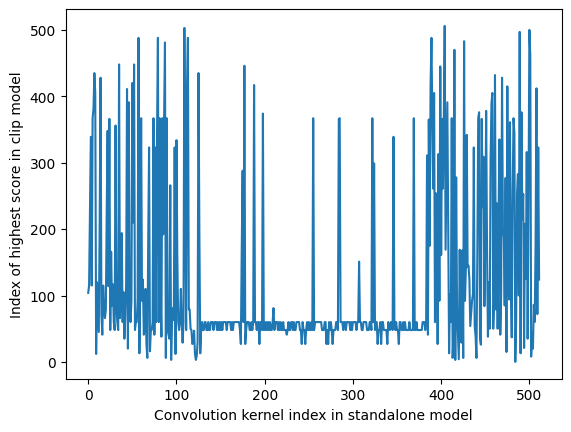

In [26]:
match_scores, clip_idxs = torch.max(table, 1)

plt.plot(match_scores.cpu().numpy())
plt.xlabel("Convolution kernel index in standalone model")
plt.ylabel("Score")
plt.show()

plt.plot(clip_idxs.cpu().numpy())
plt.xlabel("Convolution kernel index in standalone model")
plt.ylabel("Index of highest score in clip model")
plt.show()

# layer swapping

In [27]:
def find_act(act_num, net_dict):
    layers_list = list(net_dict)
    
    layer = 0
    counter =0
    
    while act_num >= counter:
        layer +=1
        counter += net_dict[layers_list[layer-1]]
        
        
    act = act_num-counter+net_dict[layers_list[layer-1]]
    
    del layers_list
    torch.cuda.empty_cache()
    return (layer-1), act

In [28]:
def resize_and_stack(curr_layer, table, gan_activs, clip_activs, all_clip_layers, idxs, k):

    scores = match_scores[idxs]
    map_size = gan_activs.shape[2]
    clip_activ_matches = torch.zeros_like(gan_activs)
    
    for i,idx in enumerate(idxs):
        clip_act_name = find_act(idx, all_clip_layers)
        activ = clip_activs[clip_act_name[0]][:,clip_act_name[1],:,:].unsqueeze(0)
        activ = torch.nn.functional.interpolate(activ, size = (map_size,map_size), mode = "bicubic")
        clip_activ_matches[:,i,:,:] = activ
        
    scores = torch.einsum('aixy,aixy->ai', gan_activs,clip_activ_matches)/(map_size**2)
    k = clip_activ_matches.shape[1]
    print("Layer" + str(curr_layer)+": Replacing Bottom "+str(k)+" out of "+ str(clip_activ_matches.shape[1])+" units")
    vals, idxs = torch.topk(-1*scores,k=k)
    
    return (clip_activ_matches,idxs)

In [29]:
def _swap_activs(clip_model, cliplayer_name, standalone_activ, idx, clip_stats):
    """
    Use standalone layers to adapt clip layers.
    """
    def edit_rule(data, model):
        data[:,idx, :, :] = ((standalone_activ[:,idx,:,:].float()*clip_stats[1][:,idx,:,:])+ clip_stats[0][:,idx,:,:]).float()
        return data
    
    clip_model.edit_layer(cliplayer_name, edit_rule)

In [30]:
def swap_layers(img, table, standalone_model, standalone_layers, clip_model, clip_layers, standalone_statistics, clip_statistics, match_list, texts):
    
    # delete existing log-file
    LOGFILE_SWAPPING = "swapping.log"
    os.system(f"rm {LOGFILE_SWAPPING}")
    
    # local variables
    similarities = np.array([])
    
    # inference
    _ = standalone_model(img)
    _ = clip_model.model.encode_image(img)
    
    # capture activations
    standalone_activs = matching.store_activs(standalone_model,
                                              standalone_layers)
    all_standalone_layers = matching.dict_layers(standalone_activs)
    clip_activs = matching.store_activs(clip_model,
                                        clip_layers)
    all_clip_layers = matching.dict_layers(clip_activs)
    
    # normalize activations
    eps = 0.00001
    
    for i,_ in enumerate(standalone_activs):
        standalone_activs[i] = (standalone_activs[i] - standalone_statistics[i][0])/(standalone_statistics[i][1] + eps)
        
    for i,_ in enumerate(clip_activs):
        clip_activs[i] = (clip_activs[i] - clip_statistics[i][0]) / (clip_statistics[i][1] + eps)
        
    # texts
    with torch.no_grad():
        text_features = clip_model.model.encode_text(clip.tokenize(texts).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    # swap layers
    j = 0 #j keeps track of activation
    for i,_ in enumerate(clip_activs):
        match_idxs = match_list[j:j + clip_activs[i].shape[1]] # slice of activations for specific layer
        j += clip_activs[i].shape[1]
        
        # resize kernel sizes
        standalone_swaps, idxs = resize_and_stack(i, table, clip_activs[i], standalone_activs, all_standalone_layers, match_idxs, k = 0)

        # update model
        _swap_activs(clip_model, clip_layers[i], standalone_swaps, idxs, clip_statistics[i])        

        # compute CLIP similarities
        with torch.no_grad():
            image_features = clip_model.model.encode_image(img.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
        
        with open(LOGFILE_SWAPPING, "a") as f:
            f.write("{}, {}, {}, {},\n".format(similarity[0].item(),
                                                similarity[1].item(),
                                                similarity[2].item(),
                                                similarity[3].item()))
        
        # save similarities
        similarities = np.hstack((similarities, similarity)) if similarities.size else similarity

    # plot similarities over time
    return img, similarities

rm: 

Layer0: Replacing Bottom 64 out of 64 units
Layer1: Replacing Bottom 64 out of 64 units
Layer2: Replacing Bottom 256 out of 256 units
Layer3: Replacing Bottom 64 out of 64 units
Layer4: Replacing Bottom 64 out of 64 units


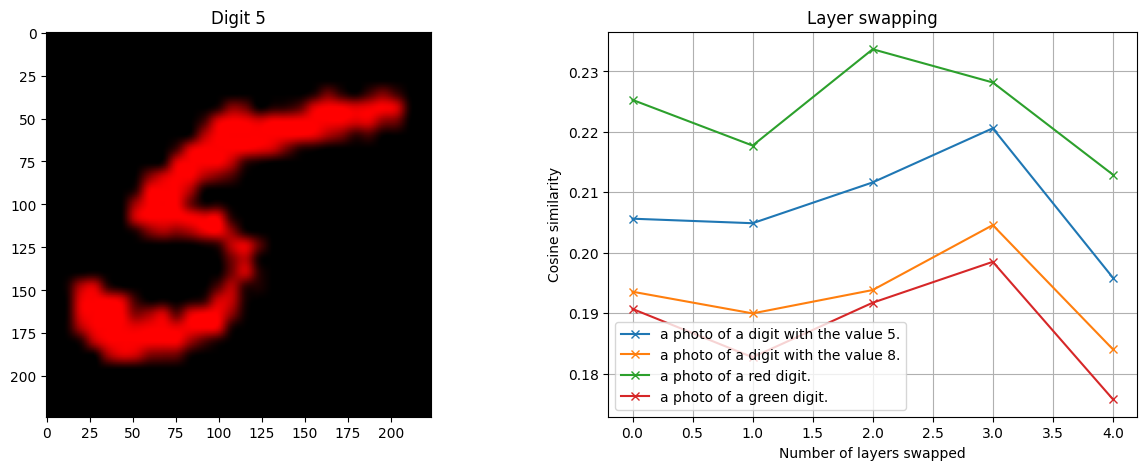

In [31]:
# setup captions
captions = ["a photo of a digit with the value 5.",
            "a photo of a digit with the value 8.",
            "a photo of a red digit.",
            "a photo of a green digit."]

# sample image
data = next(iter(data_loader))
image = data[0][0].unsqueeze(dim=0).to(device)
label = data[1][0].item()

# swap layers
img, cos_sim = swap_layers(image, table,
                           standalone_model, standalone_layers,
                           clip_model, clip_layers,
                           standalone_statistics, clip_statistics,
                           clip_idxs, captions)

# analyze cosine similarities over time
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(clip_preprocess_inverse(img.cpu(), clip_preprocess))
axs[0].set_title(f"Digit {label}")

axs[1].plot(cos_sim.T, 'x-', label=captions)
axs[1].set_title("Layer swapping")
axs[1].set_xlabel("Number of layers swapped")
axs[1].set_ylabel("Cosine similarity")
axs[1].legend()
axs[1].grid()

plt.show()